# Model based plot--> Only for sampling

In [1]:
import json
import os
import os.path as osp
import sys

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

if "__file__" in globals():
    os.chdir(os.path.dirname(__file__) + "/..")
elif "pkg" not in os.listdir("."):
    os.chdir("..")

sys.path.append(".")


def plot_v(state):
    return np.hstack((state[:, dim_I:], state[:, dim_I][:, None]))


def plot_u(state):
    return np.hstack((state[:, :dim_I], state[:, 0][:, None]))


from pkg.helper import (
    compute_kde_axis,
    estimated_autocorrelation,
)
from pkg.utils.misc import savefig

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
root_folder = "/grad/yli678/workspace/smoother_sampling/output/"
model = "Two_layer_L96_final"
foldername = (
    "/n_steps=500001,dim_I=40,sparse_obs=True,f=4.0,h=2.0,b=2.0,c=2.0,"
    + "sigma_obs=1.0,sigma_u=1.0,sigma_v=1.0"
)
output_path = root_folder + model + foldername

In [3]:
json_filename = output_path + "/config.json"
with open(json_filename, "r") as f:
    configs = json.loads(f.read())

n_steps = configs["n_steps"]
dt = configs["dt"]
dim_I = configs["dim_I"]
dim_J = configs["dim_J"]


obs_dt = 0.05
obs_n_steps = int(dt * (n_steps - 1) / obs_dt) + 1
K = int(obs_dt / dt)
t = np.linspace(0, (n_steps - 1) * dt, n_steps)
t_obs = np.linspace(0, (obs_n_steps - 1) * obs_dt, obs_n_steps)
obs_idx = np.linspace(0, int((obs_n_steps - 1)) * K, obs_n_steps)
obs_idx = obs_idx.astype(int)


model = "L96"

data_sampling = np.load(output_path + "/sampling.npz")
true_state = data_sampling["true_state"]
wrong_state = data_sampling["wrong_state"]
model_dim = true_state.shape[1]
gamma_mean_trace = data_sampling["gamma_mean_trace"]
gamma_cov_trace = data_sampling["gamma_cov_trace"]
gamma_mean_smooth = data_sampling["gamma_mean_smooth"]
gamma_cov_smooth = data_sampling["gamma_cov_smooth"]
gamma_ensembles = data_sampling["gamma_ensembles"][:, :, :10]

data_sampling_onelayer = np.load(output_path + "/sampling_onelayer.npz")

In [4]:
wrong_state_onelayer = data_sampling_onelayer["wrong_state_onelayer"]
gamma_ensembles_onelayer = data_sampling_onelayer["gamma_ensembles_onelayer"][
    :, :, :10
]
gamma_mean_smooth_onelayer = data_sampling_onelayer[
    "gamma_mean_smooth_onelayer"
]
gamma_cov_smooth_onelayer = data_sampling_onelayer["gamma_cov_smooth_onelayer"]

In [5]:
gamma_ensembles_onelayer = data_sampling_onelayer["gamma_ensembles_onelayer"][
    :, :, :10
]

In [6]:
if n_steps > 200000:
    burnin = 600  # in dt space
else:
    burnin = 150
obs_burnin = burnin // K  # in obs_dt space

auto_obs_steps = obs_n_steps - obs_burnin
t_auto = np.linspace(0, (auto_obs_steps - 1) * obs_dt, auto_obs_steps)
acf_u_truth = np.zeros((auto_obs_steps, model_dim))
acf_u_sampled = np.zeros((auto_obs_steps, model_dim))
acf_u_smooth = np.zeros((auto_obs_steps, model_dim))
acf_u_wrong = np.zeros((auto_obs_steps, model_dim))
for i in tqdm(range(model_dim)):
    acf_u_truth[:, i] = estimated_autocorrelation(
        true_state[obs_idx, i][obs_burnin:]
    )
    acf_u_sampled[:, i] = estimated_autocorrelation(
        gamma_ensembles[:, i, 0][obs_burnin:]
    )
    acf_u_smooth[:, i] = estimated_autocorrelation(
        gamma_mean_smooth[:, i][obs_burnin:]
    )
    acf_u_wrong[:, i] = estimated_autocorrelation(
        wrong_state[obs_idx, i][obs_burnin:]
    )

100%|██████████| 200/200 [00:22<00:00,  8.70it/s]


In [7]:
acf_u_sampled_onelayer = np.zeros((auto_obs_steps, dim_I))
acf_u_smooth_onelayer = np.zeros((auto_obs_steps, dim_I))
acf_u_wrong_onelayer = np.zeros((auto_obs_steps, dim_I))
for i in tqdm(range(dim_I)):
    acf_u_wrong_onelayer[:, i] = estimated_autocorrelation(
        wrong_state_onelayer[obs_idx, i][obs_burnin:]
    )
    acf_u_sampled_onelayer[:, i] = estimated_autocorrelation(
        gamma_ensembles[:, i, 0][obs_burnin:]
    )
    acf_u_smooth_onelayer[:, i] = estimated_autocorrelation(
        gamma_mean_smooth_onelayer[:, i][obs_burnin:]
    )

100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


## Plotting True signal

In [8]:
plt_dims = [0] + [dim_I + i for i in range(dim_J)]
print(plt_dims)

[0, 40, 41, 42, 43]


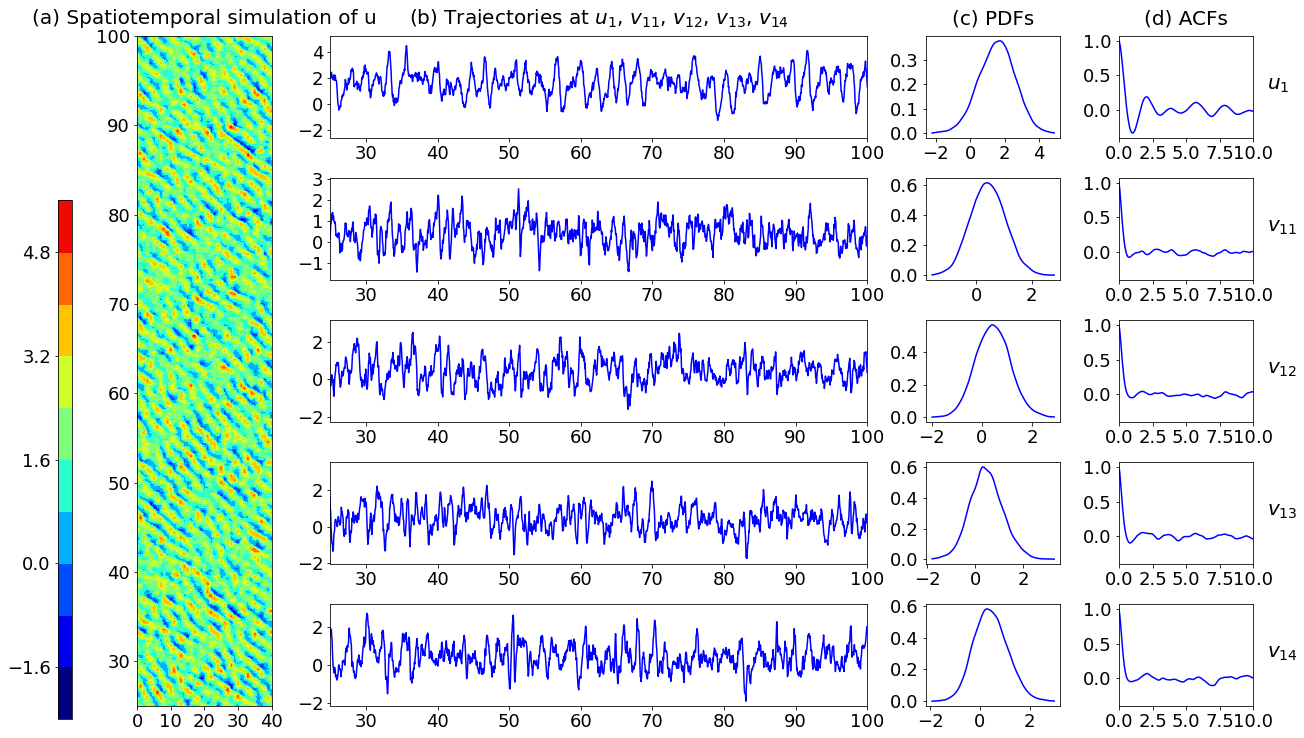

In [9]:
fontsize = 18
plt.rc("axes", titlesize=fontsize + 2)  # using a size in points
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    ncols=4,
    nrows=5,
    figsize=(20, 12),
    gridspec_kw={"width_ratios": [1, 4, 1, 1]},
)
gs = axs[-1, -1].get_gridspec()
for ax in axs[:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 0])

x_left = 25
x_right = 100
t_start = int(x_left / obs_dt)
t_end = int(x_right / obs_dt) + 1

vmax = 6
vmin = -2
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(true_state)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)

axbig.set_title("(a) Spatiotemporal simulation of u", pad=12)
cax = fig.add_axes([0.07, 0.11, 0.01, 0.6])
cbar = fig.colorbar(cf, cax=cax, ticklocation="left")

# axbig.set_ylim([x_left, x_right])

for i in range(len(plt_dims)):
    plt_dim = plt_dims[i]
    u = true_state[obs_idx, plt_dim]
    axs[i, 1].plot(t_obs, u, "b")
    axs[i, 1].set_xlim([x_left, x_right])
    kde_u, u_axis = compute_kde_axis(u, num=200)
    axs[i, 2].plot(u_axis, kde_u(u_axis), color="b", label="Truth")

    axs[i, 3].plot(t_auto, acf_u_truth[:, plt_dim], "b")
    axs[i, 3].set_xlim([0, 10])

    if i == 0:
        y_lim = axs[i, 3].get_ylim()
    else:
        axs[i, 3].set_ylim(y_lim)
axs[0, 1].set_title(
    "(b) Trajectories at $u_1$, $v_{11}$, $v_{12}$, $v_{13}$, $v_{14}$", pad=12
)
axs[0, 2].set_title("(c) PDFs", pad=12)
axs[0, 3].set_title("(d) ACFs", pad=12)

x_loc = 11
y_loc = 0.3
axs[0, 3].text(x_loc, y_loc, "$u_1$", fontsize=fontsize + 2)
axs[1, 3].text(x_loc, y_loc, "$v_{11}$", fontsize=fontsize + 2)
axs[2, 3].text(x_loc, y_loc, "$v_{12}$", fontsize=fontsize + 2)
axs[3, 3].text(x_loc, y_loc, "$v_{13}$", fontsize=fontsize + 2)
axs[4, 3].text(x_loc, y_loc, "$v_{14}$", fontsize=fontsize + 2)
plt.subplots_adjust(wspace=0.25, hspace=0.4, top=0.9)
savefig(fig, osp.join(output_path, model + "_trajectory_truth" + ".pdf"))

plt.rcdefaults()

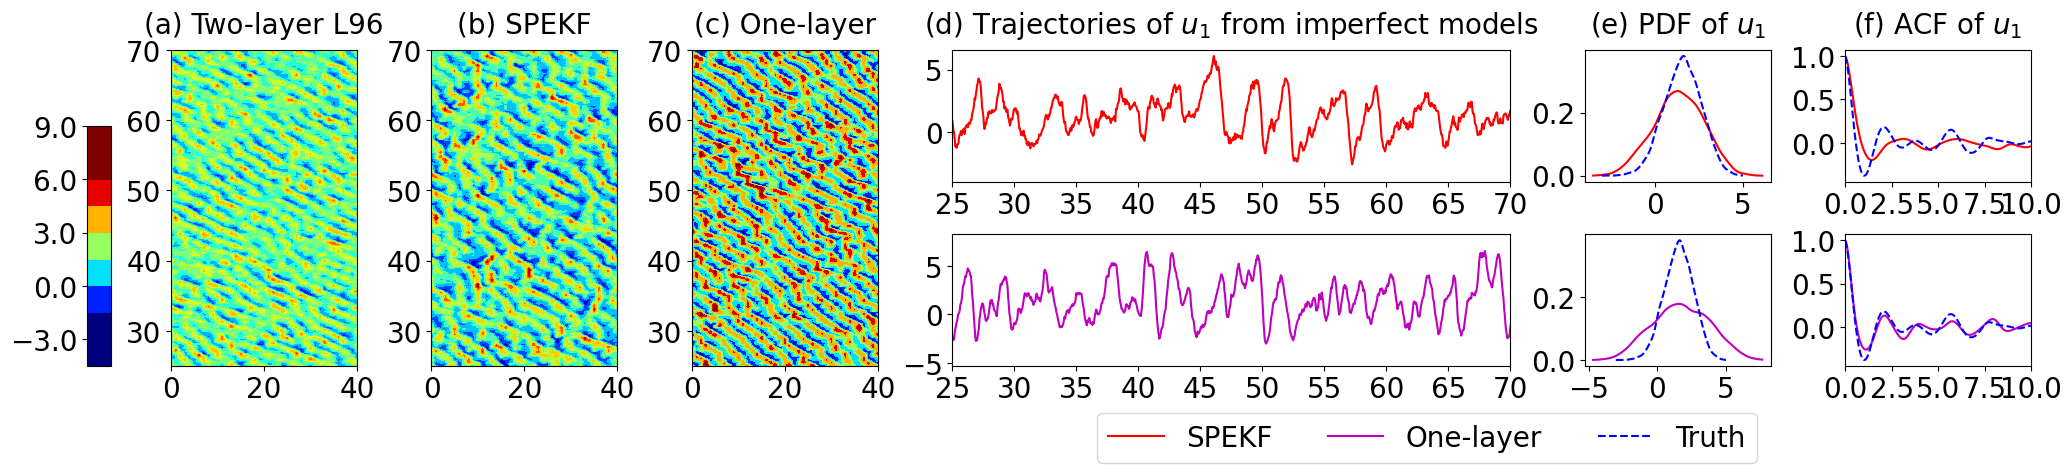

In [12]:
plt.rc("axes", titlesize=20)  # using a size in points
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)

fig, axs = plt.subplots(
    ncols=6,
    nrows=2,
    figsize=(24, 4),
    gridspec_kw={"width_ratios": [1, 1, 1, 3, 1, 1]},
)
gs = axs[-1, -1].get_gridspec()


x_left = 25
x_right = 70
t_start = int(x_left / obs_dt)
t_end = int(x_right / obs_dt) + 1

vmax = 6
vmin = -2

for ax in axs[:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 0])
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(true_state)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)
axbig.set_title("(a) Two-layer L96", pad=12)
axbig.locator_params(axis="x", nbins=3)
axbig.locator_params(axis="y", nbins=8)

for ax in axs[:, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 1])
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(wrong_state)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)
axbig.set_title("(b) SPEKF", pad=12)
axbig.locator_params(axis="x", nbins=3)
axbig.locator_params(axis="y", nbins=8)

for ax in axs[:, 2]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 2])
X, Y = np.meshgrid(np.arange(0, (dim_I + 1)), t_obs[t_start:t_end])
Z = plot_u(wrong_state_onelayer)[obs_idx][t_start:t_end]
cf = axbig.contourf(X, Y, Z, 10, cmap="jet", vmin=vmin, vmax=vmax)
axbig.set_title("(c) One-layer", pad=12)
axbig.locator_params(axis="x", nbins=3)
axbig.locator_params(axis="y", nbins=8)

cax = fig.add_axes([0.09, 0.11, 0.01, 0.6])
cbar = fig.colorbar(cf, cax=cax, ticklocation="left")
cbar.ax.locator_params(nbins=5)

plt_dim = 1


u = wrong_state[obs_idx, plt_dim]
axs[0, 3].plot(t_obs, u, "r")
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[0, 4].plot(u_axis, kde_u(u_axis), color="r", label="SPEKF")
u = true_state[obs_idx, plt_dim]
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[0, 4].plot(u_axis, kde_u(u_axis), "--", color="b", label="Truth")
axs[0, 5].plot(t_auto, acf_u_wrong[:, plt_dim], "r")
axs[0, 5].plot(t_auto, acf_u_truth[:, plt_dim], "--", color="b")


u = wrong_state_onelayer[obs_idx, plt_dim]
axs[1, 3].plot(t_obs, u, "m")
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[1, 4].plot(u_axis, kde_u(u_axis), color="m", label="One-layer")
axs[1, 5].plot(t_auto, acf_u_wrong_onelayer[:, plt_dim], "m")
u = true_state[obs_idx, plt_dim]
kde_u, u_axis = compute_kde_axis(u, num=200)
axs[1, 4].plot(u_axis, kde_u(u_axis), "--", color="b", label="Truth")
axs[1, 5].plot(t_auto, acf_u_truth[:, plt_dim], "--", color="b")

axs[0, 3].set_xlim([x_left, x_right])
axs[1, 3].set_xlim([x_left, x_right])

axs[1, 5].set_xlim([0, 10])
axs[0, 5].set_xlim([0, 10])

axs[0, 3].locator_params(axis="y", nbins=3)
axs[0, 4].locator_params(nbins=3)

axs[0, 3].set_title("(d) Trajectories of $u_1$ from imperfect models", pad=12)
axs[0, 4].set_title("(e) PDF of $u_1$", pad=12)
axs[0, 5].set_title("(f) ACF of $u_1$", pad=12)

handles1, labels1 = axs[0, 4].get_legend_handles_labels()
handles2, labels2 = axs[1, 4].get_legend_handles_labels()
handles = [handles1[0]] + handles2
labels = [labels1[0]] + labels2

axs[-1, 4].legend(
    handles, labels, ncol=3, loc="upper right", bbox_to_anchor=(1, -0.25)
)

plt.subplots_adjust(wspace=0.3, hspace=0.4, top=0.9)
savefig(
    fig, osp.join(output_path, model + "_trajectory_truth_vs_wrong" + ".pdf")
)

plt.rcdefaults()

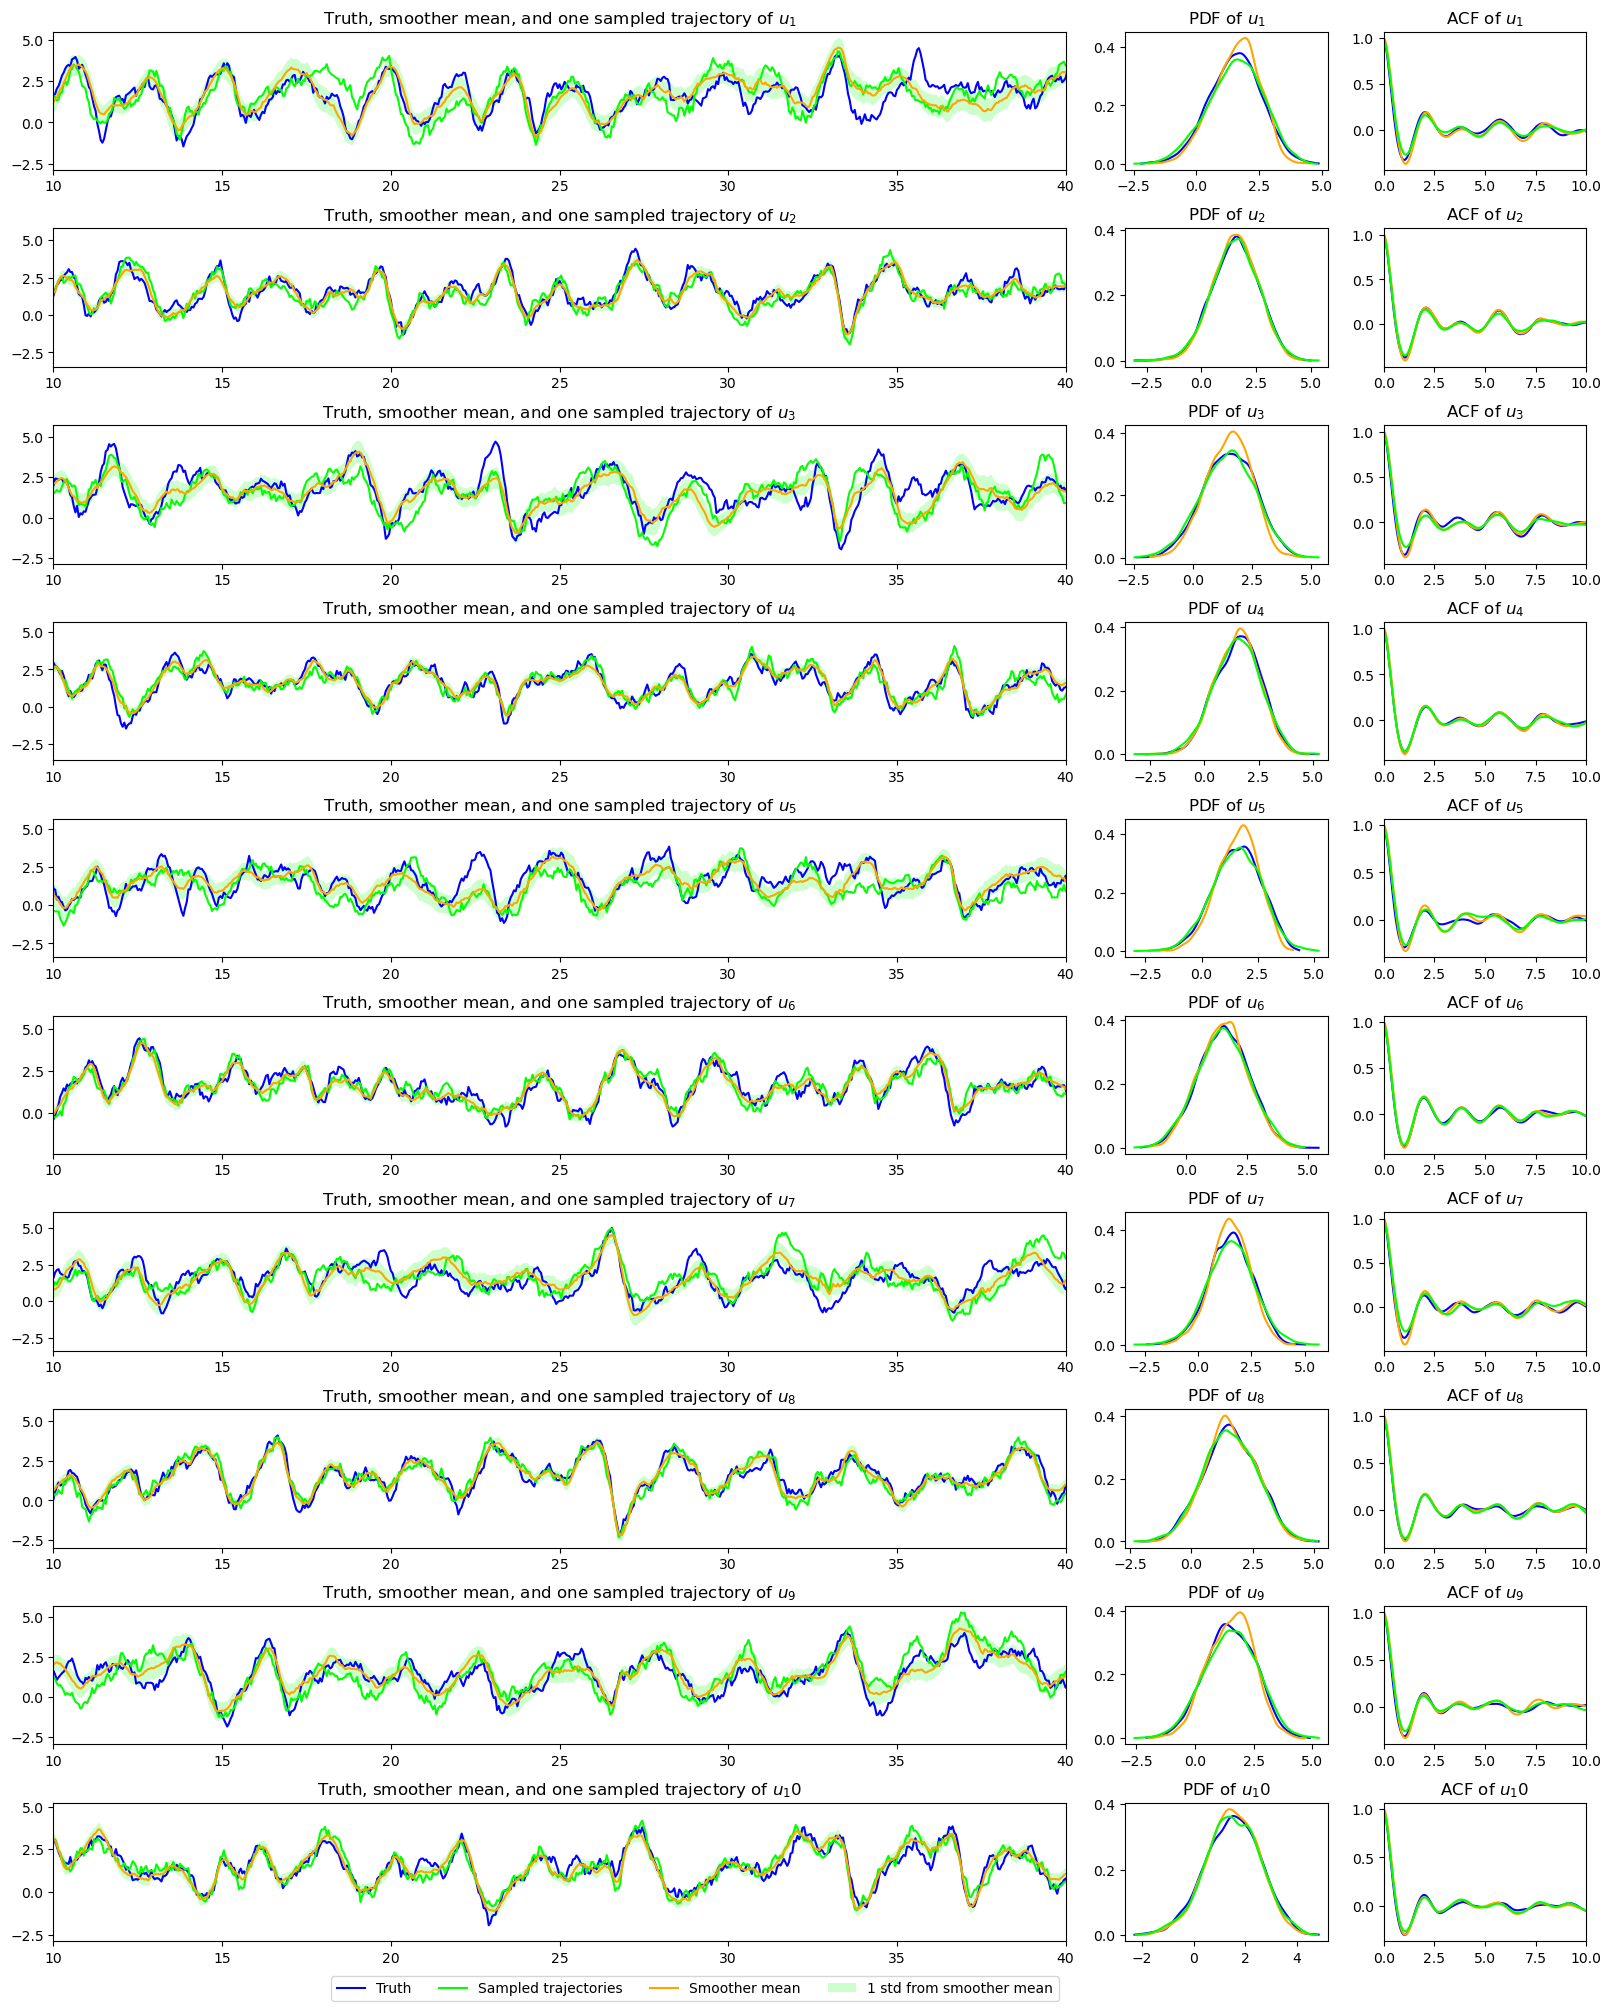

In [12]:
fig, axs = plt.subplots(
    nrows=10,
    ncols=3,
    figsize=(16, 2 * (10)),
    constrained_layout=True,
    gridspec_kw={"width_ratios": [5, 1, 1]},
)

x_left = 10
x_right = 40
for i in range(10):
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        true_state[obs_idx, i][obs_burnin:],
        "b",
        label="Truth",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    smoothing_upper_u = gamma_mean_smooth[:, i][obs_burnin:] + np.sqrt(
        gamma_cov_smooth[:, i, i][obs_burnin:]
    )
    smoothing_lower_u = gamma_mean_smooth[:, i][obs_burnin:] - np.sqrt(
        gamma_cov_smooth[:, i, i][obs_burnin:]
    )
    u = true_state[obs_idx, i][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b")
    axs[i, 2].plot(t_auto, acf_u_truth[:, i], color="b")
    u = gamma_mean_smooth[:, i][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="orange")
    axs[i, 2].plot(t_auto, acf_u_smooth[:, i], color="orange")

    u = gamma_ensembles[:, i, 0][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="lime")
    axs[i, 2].plot(t_auto, acf_u_sampled[:, i], color="lime")

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_ensembles[:, i, 0][obs_burnin:],
        "lime",
        label="Sampled trajectories",
    )
    axs[i, 0].fill_between(
        t_obs[obs_burnin:],
        smoothing_upper_u,
        smoothing_lower_u,
        facecolor="lime",
        alpha=0.2,
        label="1 std from smoother mean",
    )

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_mean_smooth[:, i][obs_burnin:],
        "orange",
        label="Smoother mean",
    )
    axs[i, 0].set_xlim([x_left, x_right])

    axs[i, 0].set_title(
        f"Truth, smoother mean, and one sampled trajectory of $u_{i + 1}$"
    )
    axs[i, 1].set_title(f"PDF of $u_{i + 1}$")
    axs[i, 2].set_title(f"ACF of $u_{i + 1}$")

    axs[i, 2].set_xlim([0, 10])
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, 0].legend(
    handles, labels, ncol=4, loc="upper right", bbox_to_anchor=(1, -0.20)
)
savefig(
    fig,
    osp.join(output_path, model + "_PDFs_ACFs_SPEKF.pdf"),
)

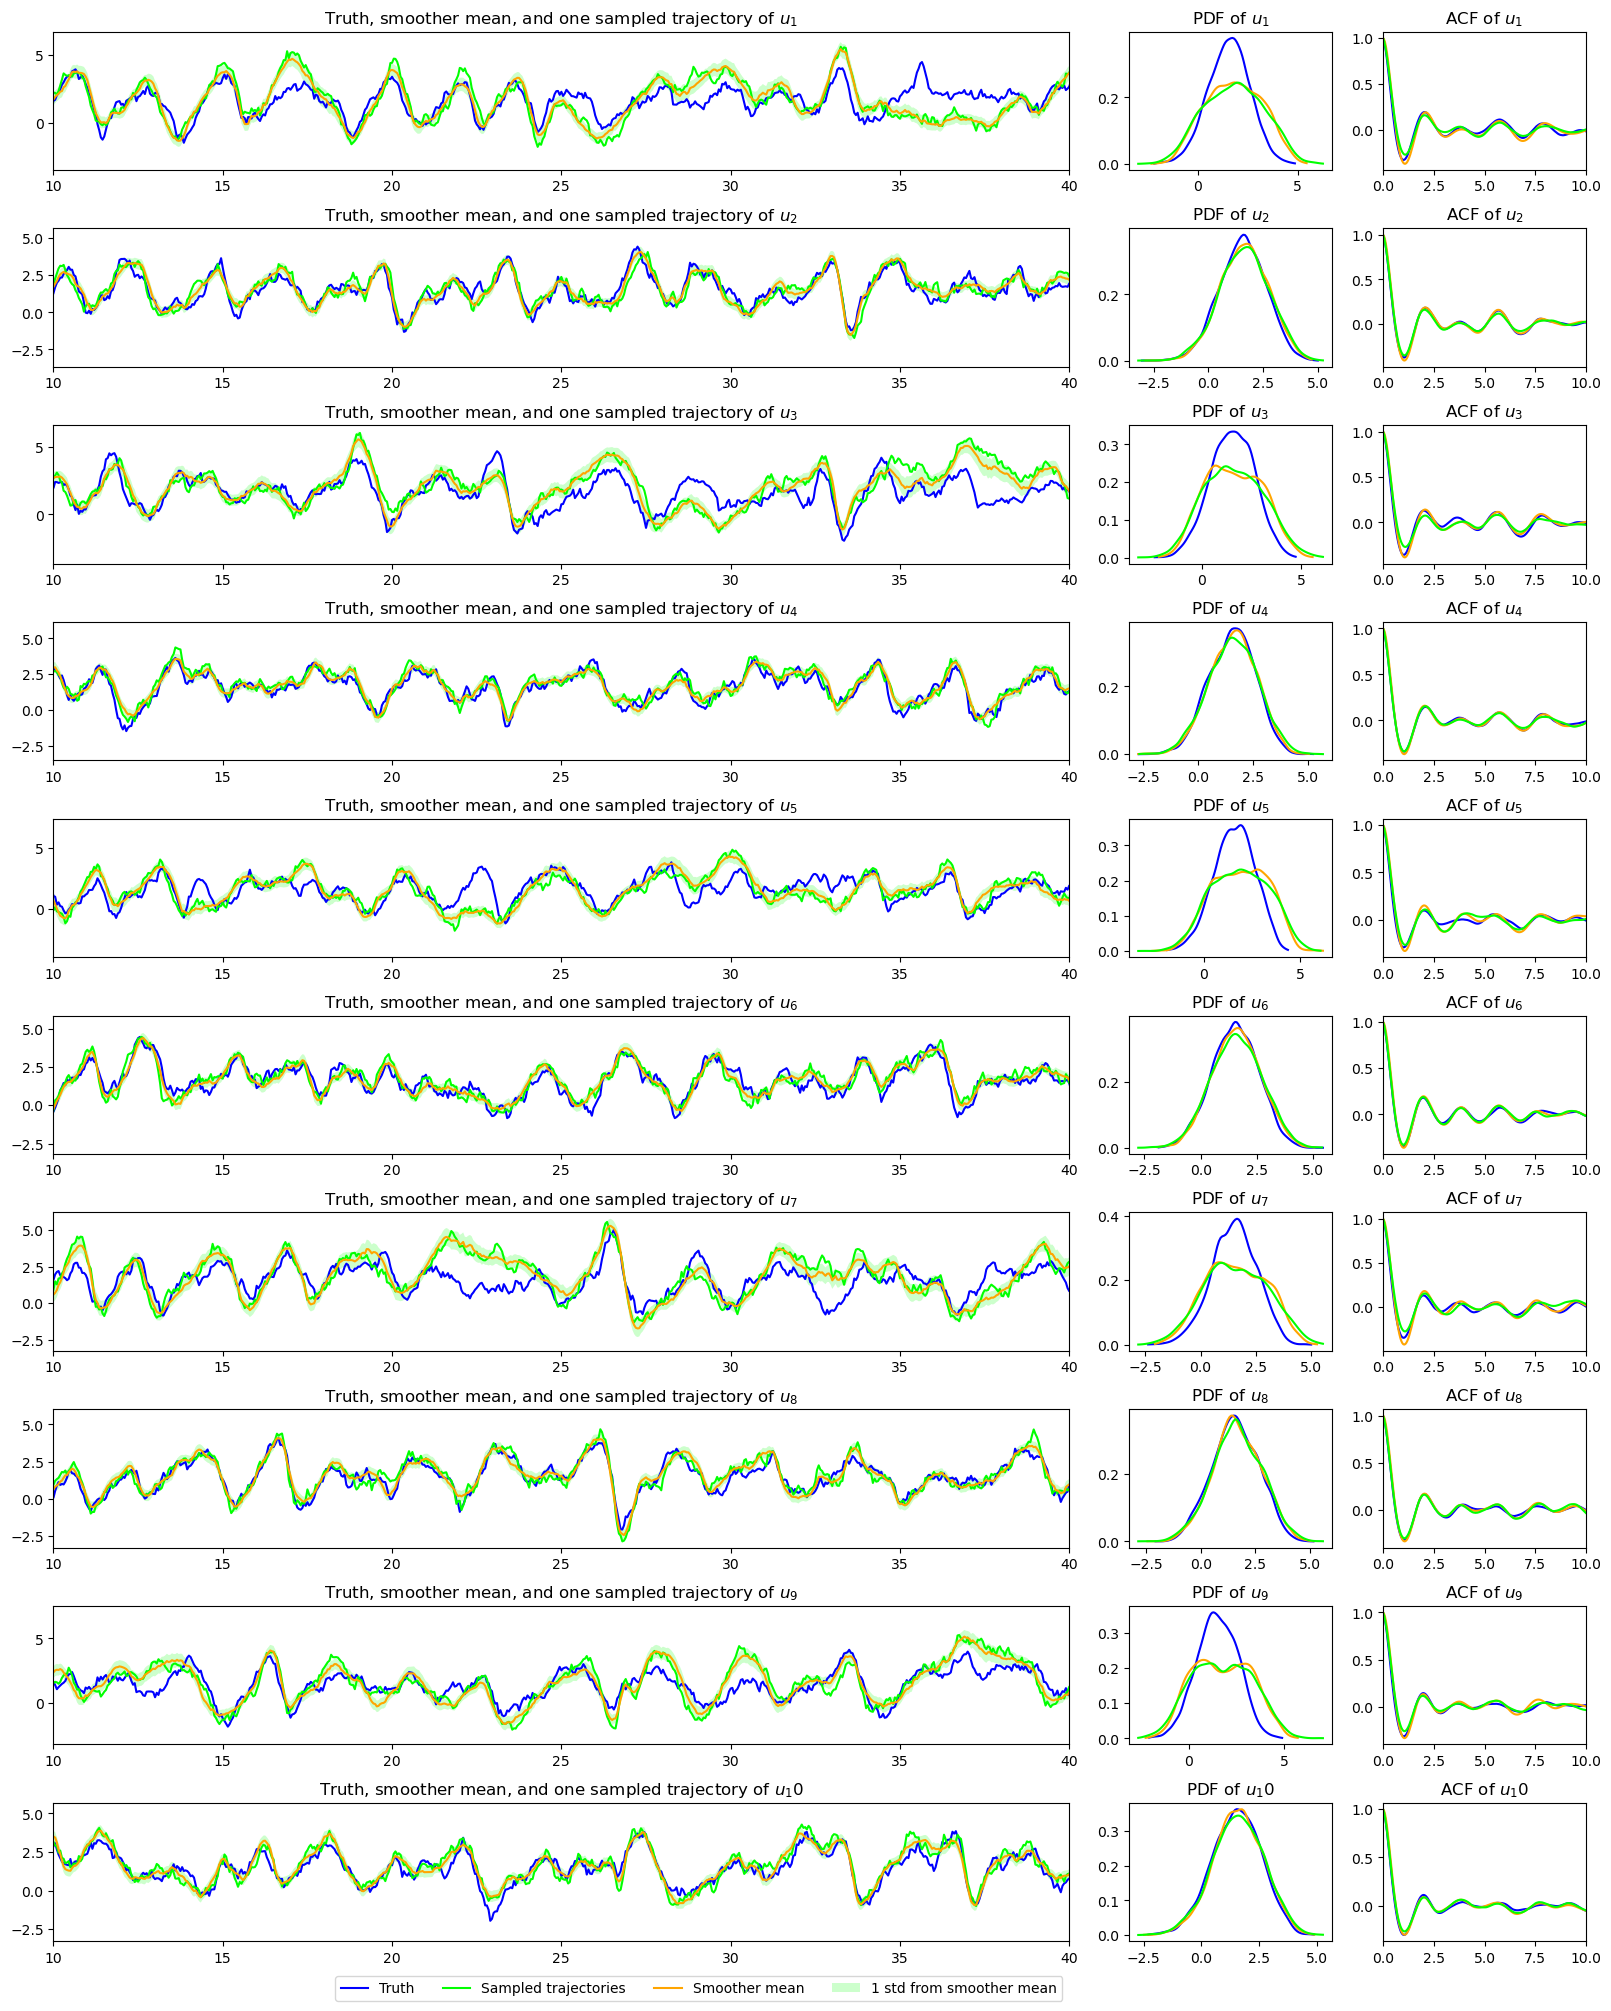

In [13]:
fig, axs = plt.subplots(
    nrows=10,
    ncols=3,
    figsize=(16, 2 * (10)),
    constrained_layout=True,
    gridspec_kw={"width_ratios": [5, 1, 1]},
)

x_left = 10
x_right = 40

for i in range(10):
    plt_dim = i
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        true_state[obs_idx, plt_dim][obs_burnin:],
        "b",
        label="Truth",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    smoothing_upper_u = gamma_mean_smooth_onelayer[:, plt_dim][
        obs_burnin:
    ] + np.sqrt(gamma_cov_smooth_onelayer[:, plt_dim, plt_dim][obs_burnin:])
    smoothing_lower_u = gamma_mean_smooth_onelayer[:, plt_dim][
        obs_burnin:
    ] - np.sqrt(gamma_cov_smooth_onelayer[:, plt_dim, plt_dim][obs_burnin:])
    u = true_state[obs_idx, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b")
    axs[i, 2].plot(t_auto, acf_u_truth[:, plt_dim], color="b")
    u = gamma_mean_smooth_onelayer[:, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="orange")
    axs[i, 2].plot(t_auto, acf_u_smooth[:, plt_dim], color="orange")

    u = gamma_ensembles_onelayer[:, i, 0][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="lime")
    axs[i, 2].plot(t_auto, acf_u_sampled[:, plt_dim], color="lime")

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_ensembles_onelayer[:, plt_dim, 0][obs_burnin:],
        "lime",
        label="Sampled trajectories",
    )
    axs[i, 0].fill_between(
        t_obs[obs_burnin:],
        smoothing_upper_u,
        smoothing_lower_u,
        facecolor="lime",
        alpha=0.2,
        label="1 std from smoother mean",
    )

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        gamma_mean_smooth_onelayer[:, plt_dim][obs_burnin:],
        "orange",
        label="Smoother mean",
    )
    axs[i, 0].set_xlim([x_left, x_right])

    axs[i, 0].set_title(
        f"Truth, smoother mean, and one sampled trajectory of $u_{plt_dim + 1}$"
    )
    axs[i, 1].set_title(f"PDF of $u_{plt_dim + 1}$")
    axs[i, 2].set_title(f"ACF of $u_{plt_dim + 1}$")

    axs[i, 2].set_xlim([0, 10])
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, 0].legend(
    handles, labels, ncol=4, loc="upper right", bbox_to_anchor=(1, -0.20)
)
savefig(
    fig,
    osp.join(output_path, model + "_PDFs_ACFs_onelayer.pdf"),
)